# 📘 Notebook 2 — Modeling and Classification

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import matplotlib.ticker as mtick
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD PROCESSED DATA
# ===============================================================

DATA_PATH = DATA_PROCESSED / "esg_processed.csv"
df = pd.read_csv(DATA_PATH)
print(f"✅ Data loaded successfully. Shape: {df.shape}")

# Inspect briefly
display(df.head())
display(df["ESG_Class"].value_counts(normalize=True))

✅ Data loaded successfully. Shape: (11000, 17)


,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,ESG_Class
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,4.9,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7,0
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4,0
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9,0
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2,0
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8,0


ESG_Class
0    0.621
1    0.379
Name: proportion, dtype: float64

In [3]:
# %% ===============================================================
# STEP 2 — FEATURE SELECTION
# ===============================================================

# Drop non-numeric / identifiers
drop_cols = ["CompanyID", "CompanyName", "Industry", "Region", "Year"]
X = df.drop(columns=drop_cols + ["ESG_Class", "ESG_Overall"], errors="ignore")
y = df["ESG_Class"]

print(f"✅ Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

✅ Features shape: (11000, 10)
Target distribution:
ESG_Class
0    0.621
1    0.379
Name: proportion, dtype: float64


In [4]:
# %% ===============================================================
# STEP 3 — TRAIN / TEST SPLIT & SCALING
# ===============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Train shape: (8250, 10), Test shape: (2750, 10)


📊 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1708
           1       0.99      1.00      1.00      1042

    accuracy                           1.00      2750
   macro avg       1.00      1.00      1.00      2750
weighted avg       1.00      1.00      1.00      2750

ROC-AUC: 0.9999724678266889


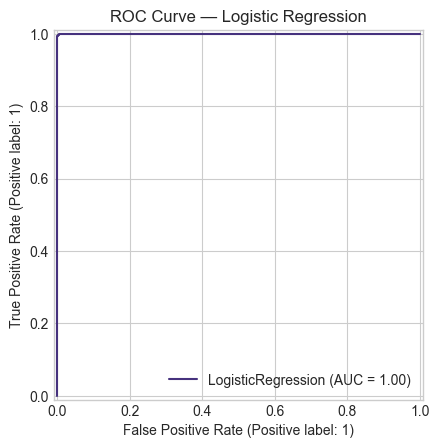

In [5]:
# %% ===============================================================
# STEP 4 — BASELINE MODEL: LOGISTIC REGRESSION
# ===============================================================

logit = LogisticRegression(random_state=42)
logit.fit(X_train_scaled, y_train)

y_pred_logit = logit.predict(X_test_scaled)
y_prob_logit = logit.predict_proba(X_test_scaled)[:, 1]

print("📊 Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logit))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_logit))

RocCurveDisplay.from_estimator(logit, X_test_scaled, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()

📊 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1708
           1       0.97      0.95      0.96      1042

    accuracy                           0.97      2750
   macro avg       0.97      0.97      0.97      2750
weighted avg       0.97      0.97      0.97      2750

ROC-AUC: 0.9972821811774331


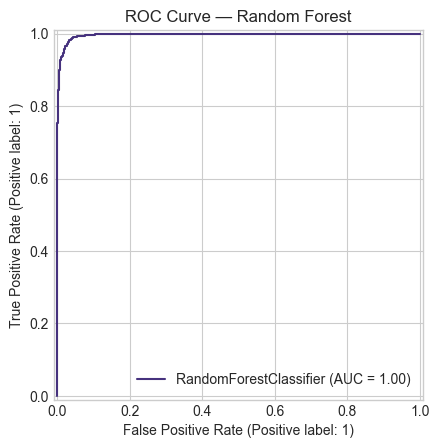

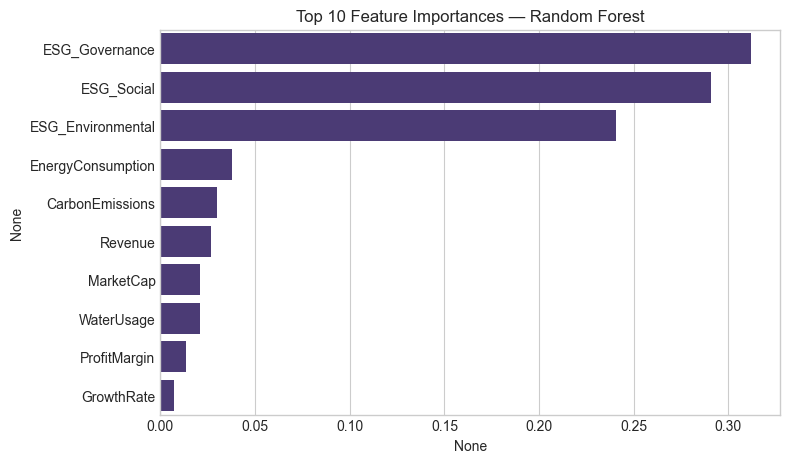

In [6]:
# %% ===============================================================
# STEP 5 — RANDOM FOREST CLASSIFIER
# ===============================================================

rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("📊 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve — Random Forest")
plt.show()

# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances — Random Forest")
plt.show()

📊 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1708
           1       0.98      0.98      0.98      1042

    accuracy                           0.99      2750
   macro avg       0.98      0.98      0.98      2750
weighted avg       0.99      0.99      0.99      2750

ROC-AUC: 0.9990616585830708


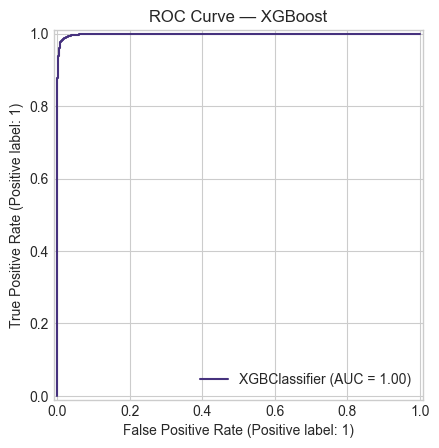

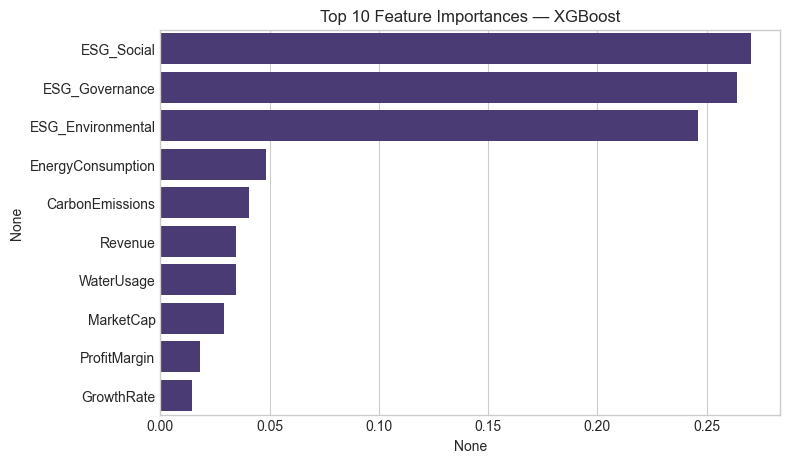

In [7]:
# %% ===============================================================
# STEP 6 — XGBOOST CLASSIFIER
# ===============================================================

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("📊 XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve — XGBoost")
plt.show()

# Feature importance (XGBoost)
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importance[:10], y=xgb_importance.index[:10])
plt.title("Top 10 Feature Importances — XGBoost")
plt.show()

,ROC_AUC
Logistic Regression,0.999972
XGBoost,0.999062
Random Forest,0.997282


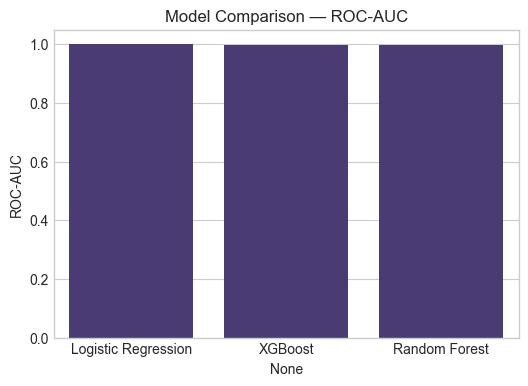

✅ Notebook 02 — Modeling and Classification complete.


In [8]:
# %% ===============================================================
# STEP 7 — MODEL COMPARISON SUMMARY
# ===============================================================

models = {
    "Logistic Regression": roc_auc_score(y_test, y_prob_logit),
    "Random Forest": roc_auc_score(y_test, y_prob_rf),
    "XGBoost": roc_auc_score(y_test, y_prob_xgb),
}

model_scores = pd.DataFrame.from_dict(models, orient="index", columns=["ROC_AUC"])
model_scores = model_scores.sort_values("ROC_AUC", ascending=False)
display(model_scores)

plt.figure(figsize=(6,4))
sns.barplot(x=model_scores.index, y=model_scores["ROC_AUC"])
plt.title("Model Comparison — ROC-AUC")
plt.ylabel("ROC-AUC")
plt.show()

print("✅ Notebook 02 — Modeling and Classification complete.")

ExactExplainer explainer: 2751it [01:58, 21.82it/s]                          


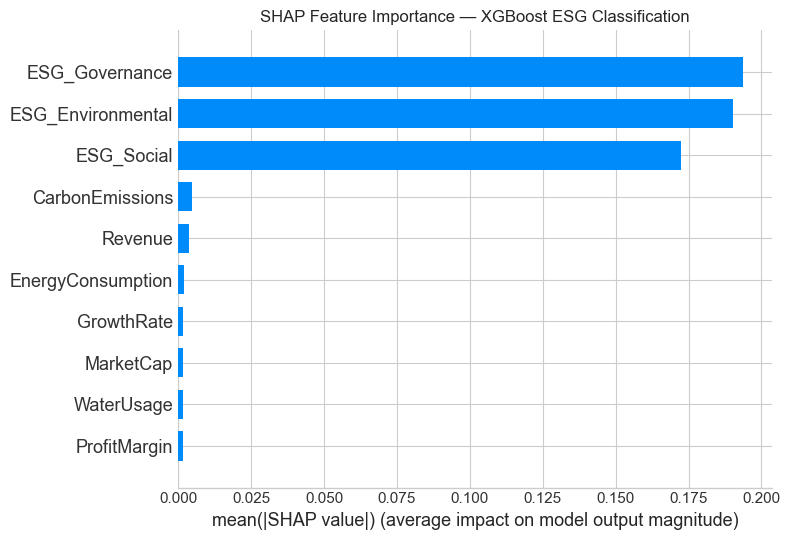

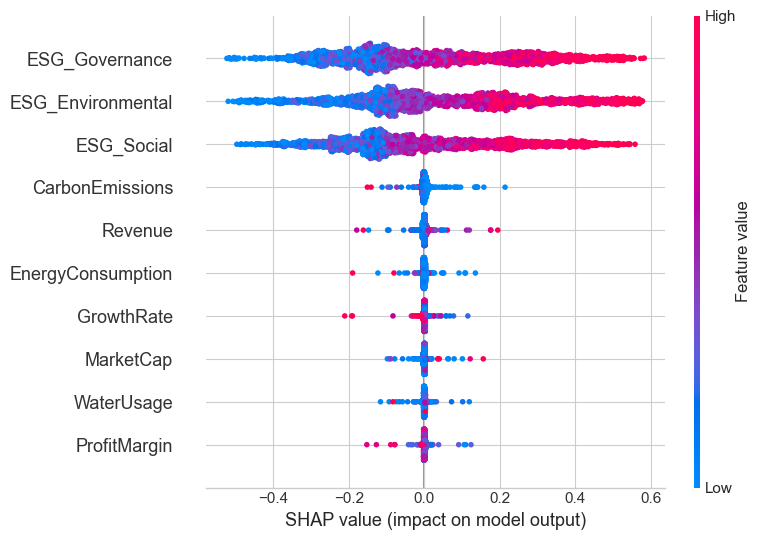

In [9]:
# %% ===============================================================
# STEP 8 — MODEL EXPLAINABILITY (SHAP)
# ===============================================================

# Convert the model into a prediction function
# (This avoids the "model not callable" TypeError)
explainer = shap.Explainer(xgb.predict, X_train)

# Compute SHAP values on the test set
shap_values = explainer(X_test)

# --- Visualize ---
# Bar summary plot — global feature importance
plt.title("SHAP Feature Importance — XGBoost ESG Classification")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.show()

# Beeswarm plot — feature-level influence
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

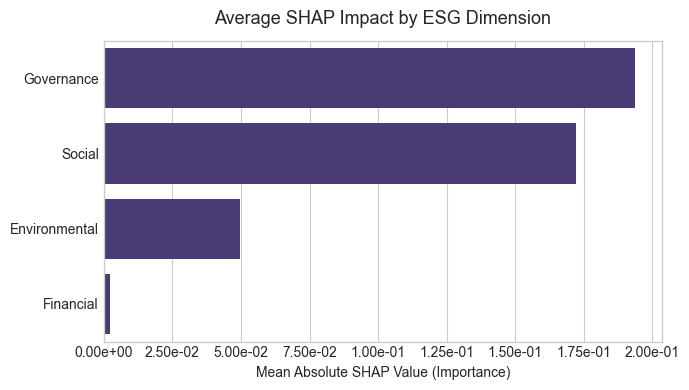

,Mean |SHAP Value|
Governance,1.94e-01
Social,1.72e-01
Environmental,4.96e-02
Financial,2.11e-03


In [10]:
# %% ===============================================================
# STEP 9 — ESG DIMENSION IMPACT ANALYSIS (GROUPED SHAP)
# ===============================================================

# Define ESG feature groups
esg_groups = {
    "Environmental": [
        "ESG_Environmental", "CarbonEmissions", "EnergyConsumption", "WaterUsage"
    ],
    "Social": ["ESG_Social"],
    "Governance": ["ESG_Governance"],
    "Financial": ["Revenue", "ProfitMargin", "MarketCap", "GrowthRate"]
}

# --- FIX: use shap_values.values to access numeric array ---
shap_array = shap_values.values  # underlying NumPy matrix (samples × features)

# Compute mean absolute SHAP value per ESG group
group_impacts = {}
for group, cols in esg_groups.items():
    cols_present = [c for c in cols if c in X_test.columns]
    if cols_present:
        idx = X_test.columns.get_indexer(cols_present)
        group_impacts[group] = np.abs(shap_array[:, idx]).mean().sum()

# Convert to DataFrame for visualization
group_impacts_df = (
    pd.Series(group_impacts)
    .sort_values(ascending=False)
    .rename("Mean |SHAP Value|")
    .to_frame()
)

# --- Plot ---
plt.figure(figsize=(7,4))
sns.barplot(
    x="Mean |SHAP Value|", 
    y=group_impacts_df.index, 
    data=group_impacts_df,
    orient="h"
)
plt.title("Average SHAP Impact by ESG Dimension", fontsize=13, pad=12)
plt.xlabel("Mean Absolute SHAP Value (Importance)")
plt.ylabel("")
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.tight_layout()
plt.show()

display(group_impacts_df.style.format("{:.2e}").background_gradient(cmap="viridis"))